# Feature Engineering: Accuracy Group of Previous Assessments 

** Note: ** This kernel was called "How to Extract Training Data From Test Data" until revision 6. In regards to the concern that utilizing test data as training data might not be good practice, the original utility function to extract the accuracy group is now used for feature engineering.

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

test_df = pd.read_csv("../input/data-science-bowl-2019/test.csv")
train_df = pd.read_csv("../input/data-science-bowl-2019/train.csv")
train_labels_df = pd.read_csv("../input/data-science-bowl-2019/train_labels.csv")

As you can see below, the test data contains earlier sessions with all events. 

For each installation_id in the test data, there is one assessment game session which only contains the very first event. For this assessment, we are expected to predict the accuracy group.

**For all other assessment game sessions in the test data (and the training data), we can extract the accuracy group from their corresponding events. This information can be used for further feature engineering, e.g. accuracy group of previous assessments of a user.**

In [2]:
# Only get assessments
test_df_assessments = test_df[test_df.type == 'Assessment']
test_df_assessments = test_df_assessments.groupby(['installation_id', 'game_session'])['event_data'].count().reset_index()

test_df_assessments.head(10)

,installation_id,game_session,event_data
0,00abaee7,348d7f09f96af313,1
1,00abaee7,8b38fc0d2fd315dc,26
2,01242218,009c890ce6c4f3e3,36
3,01242218,1fef5d54cb4b775a,1
4,01242218,31423dbcd717919e,51
5,01242218,597a8839a5a3468d,61
6,01242218,ab61cae5e3215355,83
7,01242218,e8e62de939f916bc,13
8,017c5718,4b165a330a0bdd6c,1
9,01a44906,be0b655ad1fee30c,1


# Extract Accuracy Group from Event Data
> The file train_labels.csv has been provided to show how these groups would be computed on the assessments in the training set. Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110. If the attempt was correct, it contains "correct":true.

In [3]:
import json

def estimate_accuracy_group(df):
    df = df[((df['event_code']==(2000)) |
        ((df['event_code']==(4100)) & (df['title'] != 'Bird Measurer (Assessment)')) |
             ((df['event_code']==(4110)) & (df['title'] == 'Bird Measurer (Assessment)'))) &
            (df['type']=='Assessment')]

    # Convert event_data to json object
    df['event_data_json'] = df['event_data'].apply(lambda x: json.loads(x))
    
    # Interpret event_data
    df['num_incorrect'] = df['event_data_json'].apply(lambda x: (0 if x['correct'] else 1) if 'correct' in x  else 0)
    df['num_correct'] = df['event_data_json'].apply(lambda x: (1 if x['correct'] else 0)  if 'correct' in x  else 0)
    
    # Calculate num_correct, num_incorrect and accuracy_group
    df = df.groupby('game_session').agg(num_correct_pred = ('num_correct', 'max'), 
                                        num_incorrect_pred = ('num_incorrect', 'sum'), ).reset_index()

    df['accuracy_group_pred'] = df['num_incorrect_pred'].apply(lambda x: 3 if x == 0 else (2 if x == 1 else 1)) * df['num_correct_pred']
    
    return df

# Evaluate Utility Function with Training Data and Training Labels
Let's evaluate the accuracy of our function estimate_accuracy_group() with the given test labels.

In [4]:
useful_game_sessions = train_labels_df['game_session'].unique()

# Extract accuracy_group from event_data
train_labels_pred = estimate_accuracy_group(train_df[train_df['game_session'].isin(useful_game_sessions)])

print('{} actual game sessions'.format(train_labels_df.shape[0]))
print('{} predicted game sessions'.format(train_labels_pred.shape[0]))

# Evaluation
train_labels_pred = train_labels_pred.merge(train_labels_df, on = 'game_session')
train_labels_pred['accuracy'] = train_labels_pred['accuracy_group_pred'] - train_labels_pred['accuracy_group']

print('Max. deviation between prediction and actual accuracy_group is {}'.format(train_labels_pred['accuracy'].max()))
train_labels_pred.head()
     

17690 actual game sessions
17690 predicted game sessions
Max. deviation between prediction and actual accuracy_group is 0


,game_session,num_correct_pred,num_incorrect_pred,accuracy_group_pred,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,00097cda27afb726,1,0,3,01bdd720,Mushroom Sorter (Assessment),1,0,0,3
1,000f68cff32664ef,0,6,0,3f0dca37,Chest Sorter (Assessment),0,6,0,0
2,0014403daadf67aa,1,3,1,29d1aaee,Bird Measurer (Assessment),1,3,0,1
3,0014daa1d3e26eb2,1,2,1,55fdf49f,Mushroom Sorter (Assessment),1,2,0,1
4,001c49e9e9968dbe,1,1,2,19d4b097,Bird Measurer (Assessment),1,1,0,2


# Extracting Accuracy Group for Test Data as a Feature

**As mentioned above, only assessments with a single event count are intended for prediction.**
Therefore, let's drop the actual test data to extract the accuracy group of previous assessments as features.

,game_session,num_correct_pred,num_incorrect_pred,accuracy_group_pred
0,001a139acd7fce92,1,15,1
1,003bafadf2259738,1,0,3
2,006b058c3bba11a2,1,0,3
3,007195dd54b7c251,1,0,3
4,007b28de31382377,0,1,0


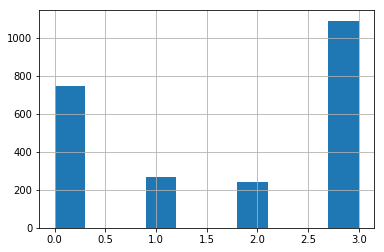

In [5]:
# Assessments with only one event are intended for predictions. These will be dropped.
drop = test_df_assessments[test_df_assessments.event_data == 1].game_session.unique()
test_df_assessments = test_df[~test_df.game_session.isin(drop)]

# Predict
test_train_labels_pred = estimate_accuracy_group(test_df_assessments)
test_train_labels_pred.accuracy_group_pred.hist()
test_train_labels_pred.head()

These extracted accuracy groups for previous assessments can now be utilized further to features such as 'average accuracy group' of a user.

**Hope this helped!**

Please feel free to leave any remarks or comments!